# Load Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import random
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

# Create Model
- Combine the three CSVs
- Split into training and test data

In [14]:
# Combine the three csvs
first_df = pd.read_csv('./dataset/users_final_games1.csv')
second_df = pd.read_csv('./dataset/users_final_games2.csv')
third_df = pd.read_csv('./dataset/users_final_games3.csv', header=None)

column_names = [
    "ID",
    "PlayerID",
    "GameID",
    "GameName",
    "GameGenre",
    "RunID",
    "RunTime",
    "CategoryType",
    "PlayerCountry",
    "PlayerPronouns",
    "PlayerSignupDate"
]

first_df.columns = column_names
second_df.columns = column_names
third_df.columns = column_names

df = pd.concat([first_df, second_df, third_df], ignore_index=True)


# Clean the data = Only include players who played more than one game 
player_game_counts = df.groupby('PlayerID')['GameID'].nunique()
valid_players = player_game_counts[player_game_counts > 1].index
df_clean = df[df['PlayerID'].isin(valid_players)]

In [18]:
train_rows = []
test_rows = []

for player_id, player_df in df_clean.groupby('PlayerID'):
    games = player_df['GameName'].unique()
    if len(games) < 5:
        continue  # skip players with too few games

    train_games, test_games = train_test_split(
        games, test_size=0.2, random_state=42
    )

    train_rows.append(player_df[player_df['GameName'].isin(train_games)])
    test_rows.append(player_df[player_df['GameName'].isin(test_games)])

train_df = pd.concat(train_rows)
test_df = pd.concat(test_rows)

In [4]:
# collaborative filtering matrix on training data
player_game_matrix = train_df.pivot_table(index='PlayerID', columns='GameName',
                                          values='RunID', aggfunc='count', fill_value=0)
player_game_matrix = (player_game_matrix > 0).astype(int)

# get the genre, category, and country
game_genre = train_df.drop_duplicates('GameName').set_index('GameName')['GameGenre'].fillna('Unknown')
game_category = train_df.drop_duplicates('GameName').set_index('GameName')['CategoryType'].fillna('Unknown')
player_country = train_df.drop_duplicates('PlayerID').set_index('PlayerID')['PlayerCountry']


In [5]:
# Recommender
def recommend_hybrid(player_game_matrix, game_genre, game_category, player_country,
                     user_games, user_country=None, country_boost=True, alpha=0.6, beta=0.2, gamma=0.2, top_n=5):
    # Collaborative = builds vector of current user's games and then calculates cosine similarity with all other players
    user_vector = pd.Series(0, index=player_game_matrix.columns)
    for game in user_games:
        if game in user_vector.index:
            user_vector[game] = 1

    similarities = cosine_similarity([user_vector], player_game_matrix.values)[0]

    # Country boost = if player is in the same country, they get a 10% boost (Optional) 
    if country_boost:
        if user_country:
            boost_indices = [i for i, pid in enumerate(player_game_matrix.index) 
                             if player_country.get(pid, None) == user_country]
            similarities[boost_indices] *= 1.1

    # find the top 30 players who are most similar to the current player 
    top_player_indices = similarities.argsort()[::-1][:30]
    # for each game, how many of the 30 most similar players played it?
    top_players = player_game_matrix.iloc[top_player_indices]
    collab_scores = top_players.sum()

    # Genre = Determine what genre the player likes and sets it to 1 
    genre_preferences = set(game_genre.get(g) for g in user_games if g in game_genre.index)
    genre_scores = pd.Series(0, index=player_game_matrix.columns)
    for game in genre_scores.index:
        if game_genre.get(game, None) in genre_preferences:
            genre_scores[game] = 1

    # Category = Determine what category the player likes and sets it to 1 
    category_preferences = set(game_category.get(g) for g in user_games if g in game_category.index)
    category_scores = pd.Series(0, index=player_game_matrix.columns)
    for game in category_scores.index:
        if game_category.get(game, None) in category_preferences:
            category_scores[game] = 1

    # Combine scores
    combined_scores = alpha * collab_scores + beta * genre_scores + gamma * category_scores
    combined_scores = combined_scores.drop(labels=user_games, errors='ignore')

    recommended_games = combined_scores.sort_values(ascending=False).head(top_n)

    return recommended_games.index.tolist()

# Evaluate Model

In [6]:
def evaluate_on_test_set(test_df, player_game_matrix, game_genre, game_category, player_country,
                                   sample_size=500, alpha=0.6, beta=0.2, gamma=0.2, top_n=5):
    recall_at_k = []
    precision_at_k = []
    mrr_scores = []
    ndcg_scores = []
    has_hit = []

    # run it on a sample of test set 
    sampled_test_players = test_df['PlayerID'].drop_duplicates().sample(sample_size)
    test_players = test_df[test_df['PlayerID'].isin(sampled_test_players)]

    for player_id in tqdm(test_players['PlayerID'].unique(), desc="Evaluating players"):
        # if the player is not in the training set, move on  
        if player_id not in player_game_matrix.index:
            continue

        # if the player doesn't have any games in training set, move on 
        input_games = player_game_matrix.columns[player_game_matrix.loc[player_id] > 0].tolist()
        if len(input_games) == 0:
            continue

        # if the player doesn't have any games in test set, move on
        true_games = test_df[test_df['PlayerID'] == player_id]['GameName'].unique().tolist()
        if not true_games:
            continue

        country = player_country.get(player_id, None)

        recs = recommend_hybrid(
            player_game_matrix, game_genre, game_category, player_country,
            input_games, user_country=country,
            alpha=alpha, beta=beta, gamma=gamma, top_n=top_n
        )

        # Hits = see if any of the recommended games were in the player's true games 
        hits = [game for game in recs if game in true_games]
        
        has_hit.append(int(len(hits) > 0))

        # Recall = how many of the true test games did we find?
        recall = len(hits) / len(true_games)
        recall_at_k.append(recall)

        # Precision = how many of the recommendations were actually relevant?
        precision = len(hits) / top_n
        precision_at_k.append(precision)

        # MRR = rank of *first* relevant item (if any)
        mrr = 0
        for rank, game in enumerate(recs, start=1):
            if game in true_games:
                mrr = 1.0 / rank
                break
        mrr_scores.append(mrr)

        # NDCG
        dcg = 0
        for rank, game in enumerate(recs, start=1):
            if game in true_games:
                dcg += 1 / math.log2(rank + 1)
        ideal_dcg = sum([1 / math.log2(i + 1) for i in range(1, min(len(true_games), top_n) + 1)])
        ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
        ndcg_scores.append(ndcg)

    results_df = pd.DataFrame({
        'Recall@5': recall_at_k,
        'Precision@5': precision_at_k,
        'MRR': mrr_scores,
        'NDCG@5': ndcg_scores,
        'Hit@5': has_hit
    })

    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    sns.histplot(results_df['Recall@5'], bins=20, color='skyblue')
    plt.title("Distribution of Recall@5")

    plt.subplot(2, 2, 2)
    sns.histplot(results_df['Precision@5'], bins=20, color='lightgreen')
    plt.title("Distribution of Precision@5")

    plt.subplot(2, 2, 3)
    sns.histplot(results_df['MRR'], bins=20, color='salmon')
    plt.title("Distribution of MRR")

    plt.subplot(2, 2, 4)
    sns.histplot(results_df['NDCG@5'], bins=20,  color='orchid')
    plt.title("Distribution of NDCG@5")

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nSummary Statistics:")
    print(results_df.describe())

    hits_total = sum(has_hit)
    misses_total = len(has_hit) - hits_total
    hit_rate = hits_total / len(has_hit) if has_hit else 0

    print(f"\nTotal Players Evaluated: {len(has_hit)}")
    print(f"Players with Hits: {hits_total}")
    print(f"Players with No Hits: {misses_total}")
    print(f"Hit Rate@{top_n}: {hit_rate:.4f}")

    return results_df


# Test on Test Set


Evaluating players: 100%|█████████████████████| 500/500 [03:14<00:00,  2.57it/s]


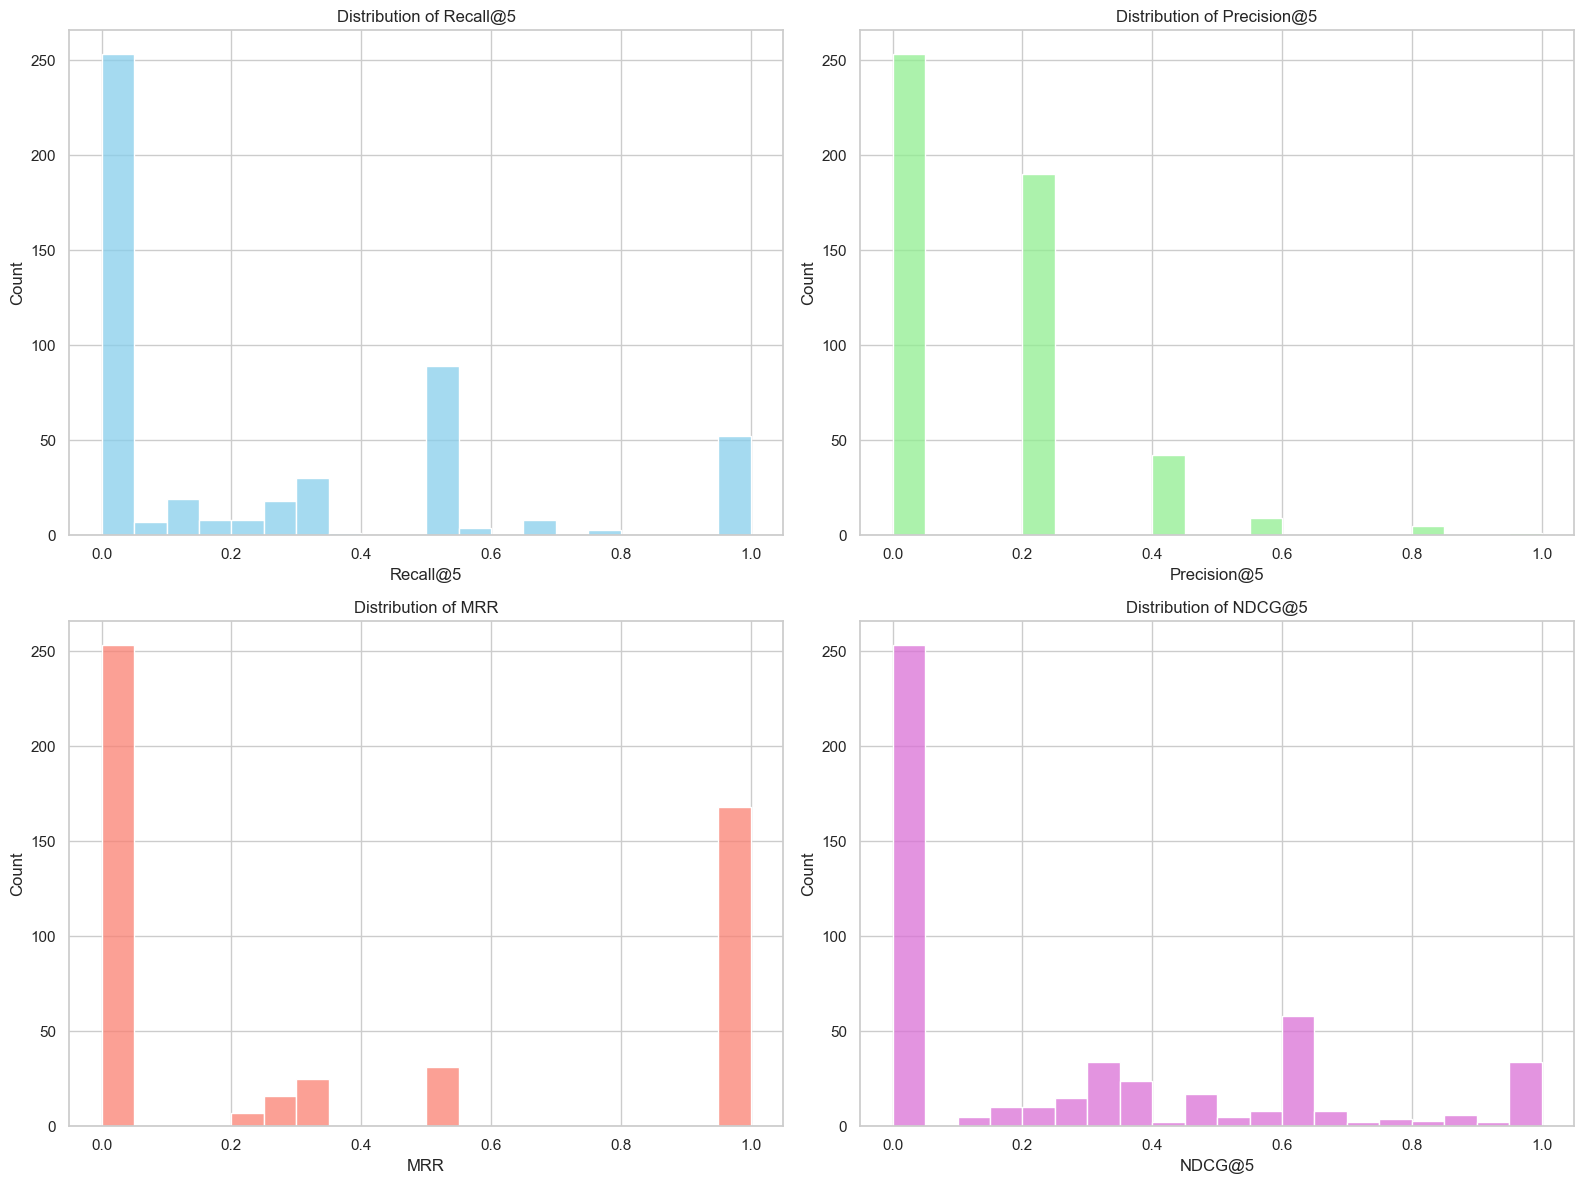


Summary Statistics:
         Recall@5  Precision@5         MRR      NDCG@5       Hit@5
count  500.000000     500.0000  500.000000  500.000000  500.000000
mean     0.254853       0.1304    0.394467    0.268564    0.494000
std      0.328988       0.1630    0.452129    0.324252    0.500465
min      0.000000       0.0000    0.000000    0.000000    0.000000
25%      0.000000       0.0000    0.000000    0.000000    0.000000
50%      0.000000       0.0000    0.000000    0.000000    0.000000
75%      0.500000       0.2000    1.000000    0.524365    1.000000
max      1.000000       1.0000    1.000000    1.000000    1.000000

Total Players Evaluated: 500
Players with Hits: 247
Players with No Hits: 253
Hit Rate@5: 0.4940
### Test Set Evaluation ###
Recall@5: 0.25485251415251414
Precision@5: 0.1304
MRR: 0.39446666666666663
NDCG@5: 0.26856446618857865
HitRate@5: 0.494
Recommended Games: ['Super Mario 64 Category Extensions', 'SM64 Sapphire', 'Minecraft: Java Edition', 'Portal', 'Super Mario Odyss

In [7]:
# Set fixed weights
# Experiment and do ablation study of just a few weight changes?
alpha = 0.7
beta = 0.1
gamma = 0.2

results = evaluate_on_test_set(
    test_df, player_game_matrix, game_genre, game_category, player_country,
    alpha=alpha, beta=beta, gamma=gamma, top_n=5
)

print("### Test Set Evaluation ###")
print("Recall@5:", results['Recall@5'].mean())
print("Precision@5:", results['Precision@5'].mean())
print("MRR:", results['MRR'].mean())
print("NDCG@5:", results['NDCG@5'].mean())
print("HitRate@5:", results['Hit@5'].mean())

# Example of player who played Celeste and Super Mario 64
user_games = ['Celeste', 'Super Mario 64']
recommendations = recommend_hybrid(
    player_game_matrix, game_genre, game_category, player_country,
    user_games,
    user_country='United States',
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    top_n=5
)

print("Recommended Games:", recommendations)

# Ablation Study
- Try out different weights

Evaluating players: 100%|███████████████████████| 50/50 [00:19<00:00,  2.61it/s]


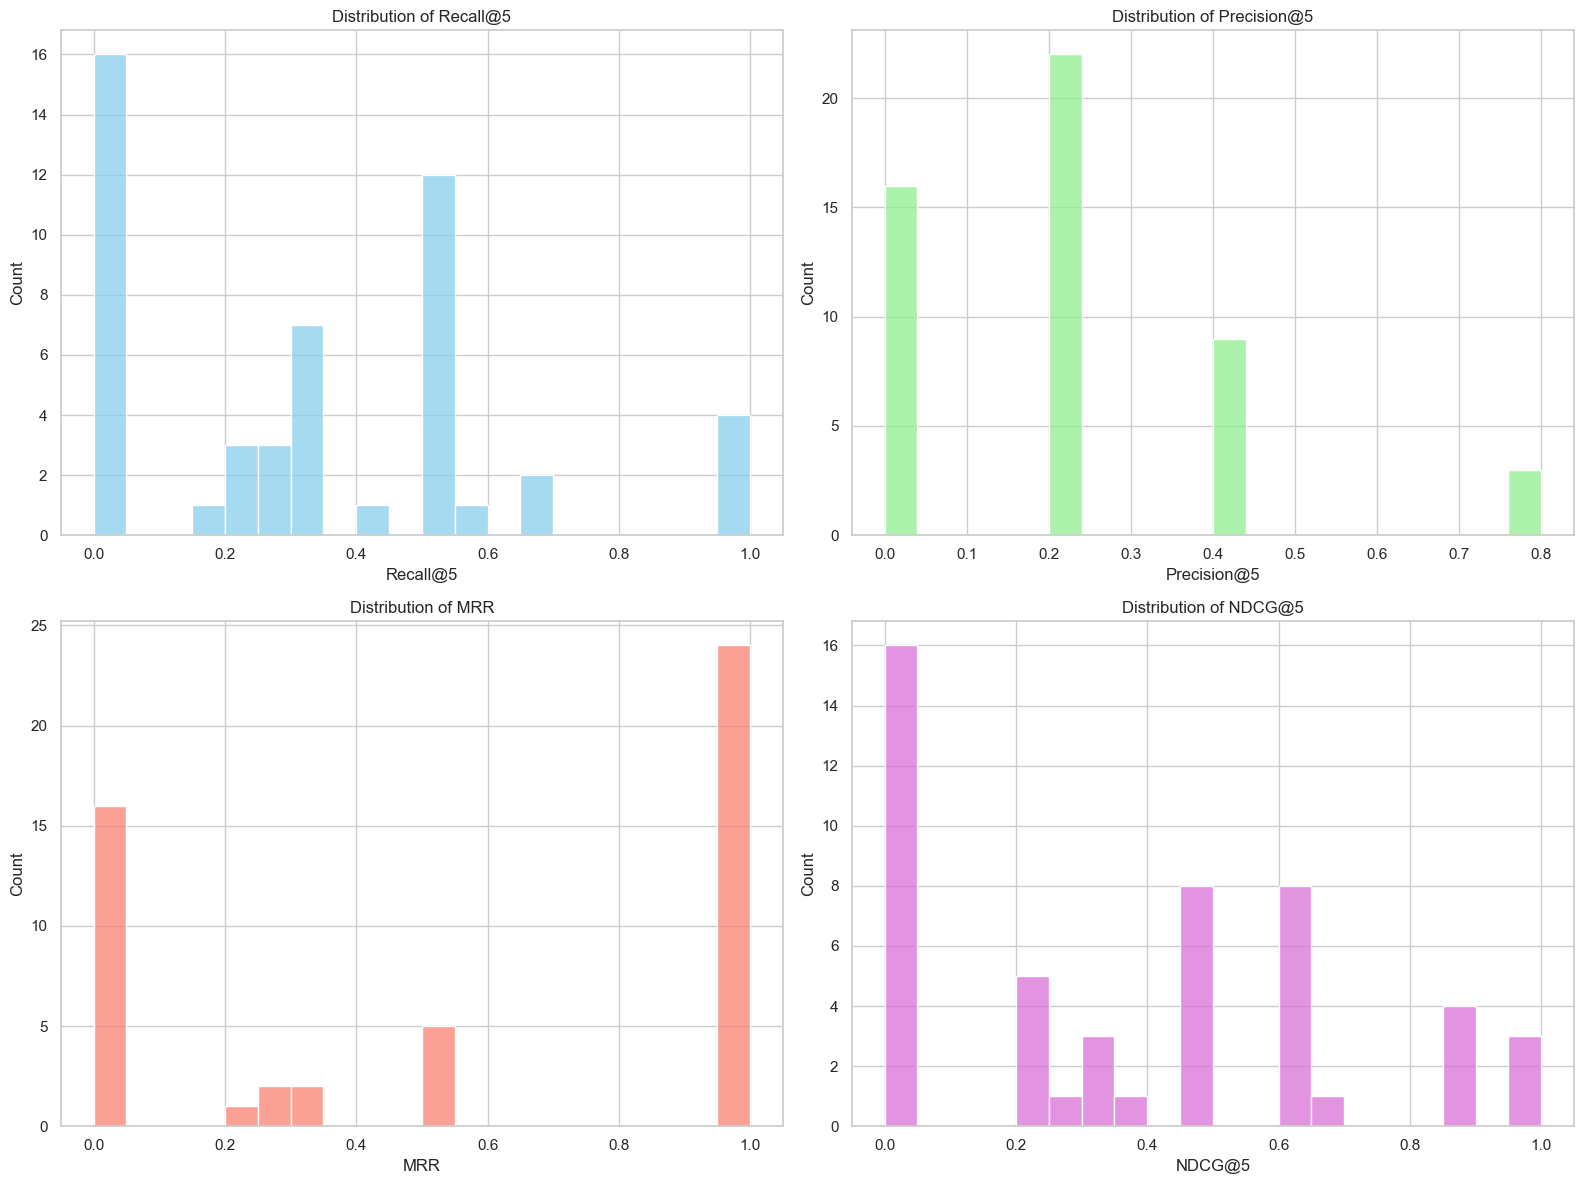


Summary Statistics:
        Recall@5  Precision@5        MRR     NDCG@5      Hit@5
count  50.000000    50.000000  50.000000  50.000000  50.000000
mean    0.323306     0.208000   0.557333   0.373015   0.680000
std     0.295077     0.205873   0.454146   0.324880   0.471212
min     0.000000     0.000000   0.000000   0.000000   0.000000
25%     0.000000     0.000000   0.000000   0.000000   0.000000
50%     0.333333     0.200000   0.500000   0.363007   1.000000
75%     0.500000     0.200000   1.000000   0.613147   1.000000
max     1.000000     0.800000   1.000000   1.000000   1.000000

Total Players Evaluated: 50
Players with Hits: 34
Players with No Hits: 16
Hit Rate@5: 0.6800


Evaluating players: 100%|███████████████████████| 50/50 [00:19<00:00,  2.56it/s]


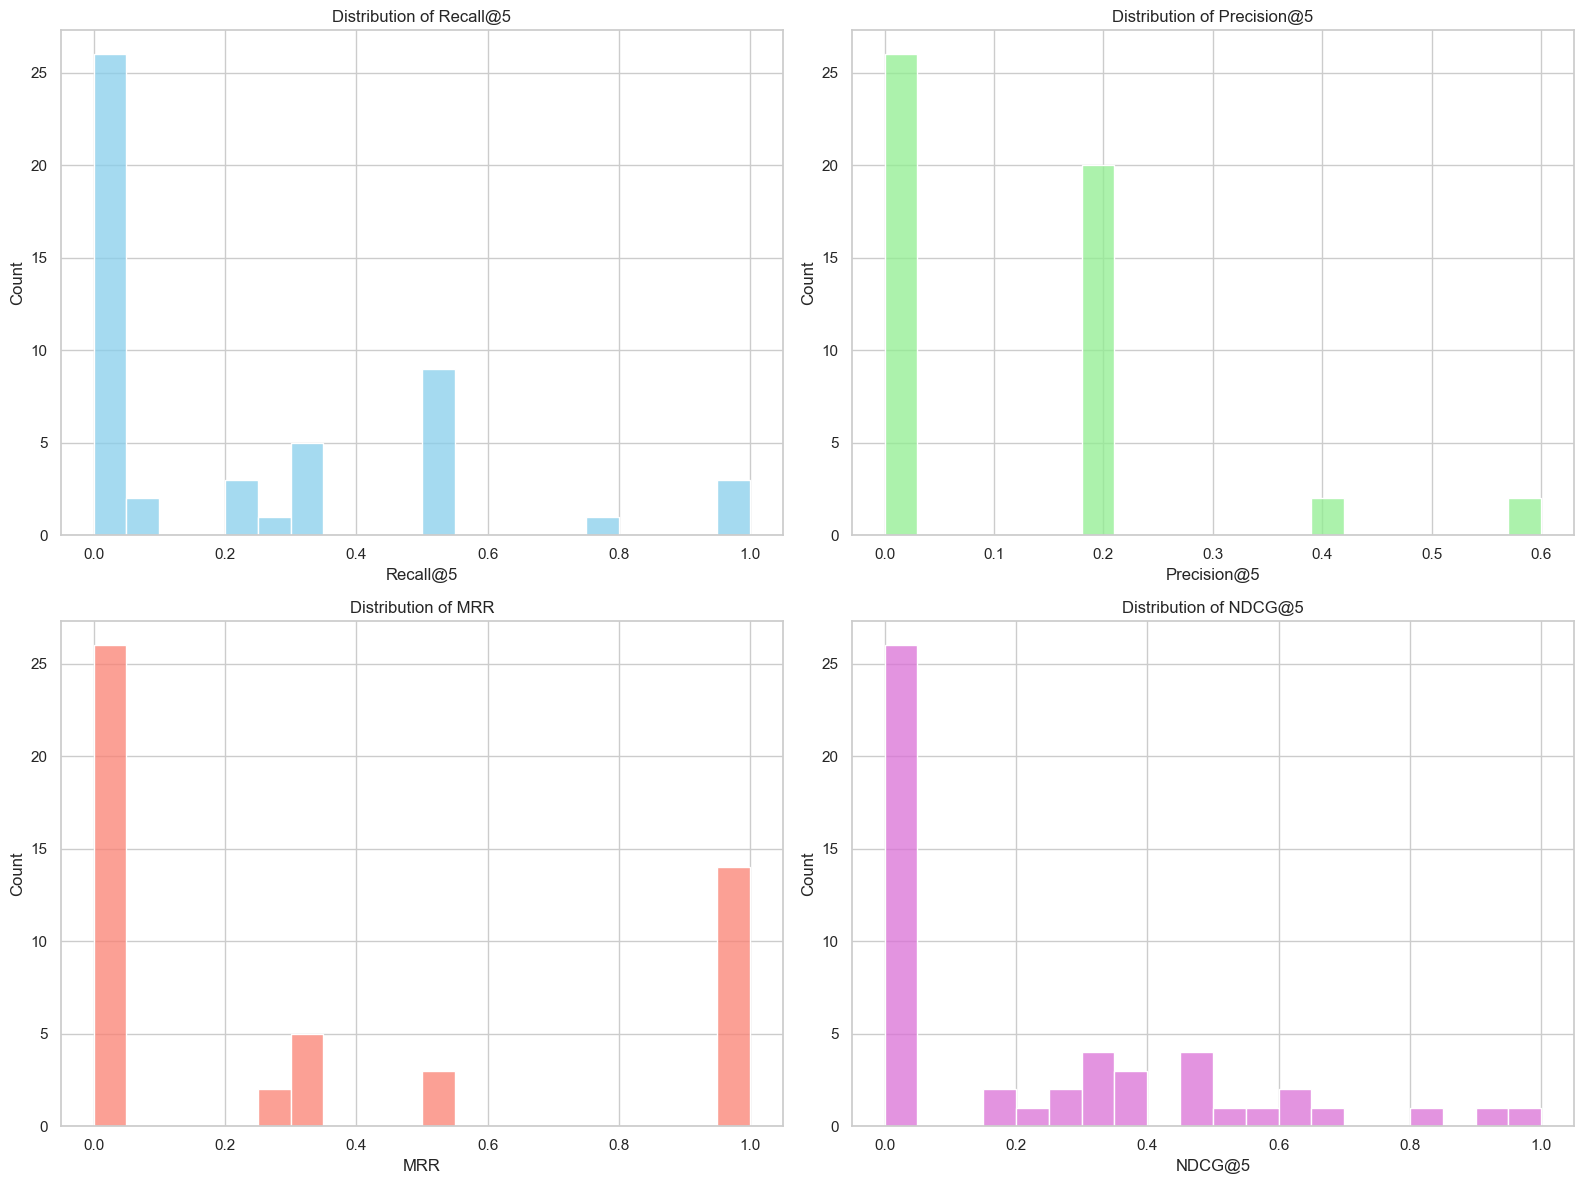


Summary Statistics:
        Recall@5  Precision@5        MRR     NDCG@5      Hit@5
count  50.000000    50.000000  50.000000  50.000000  50.000000
mean    0.217872     0.120000   0.353333   0.223659   0.480000
std     0.292267     0.151186   0.433032   0.278660   0.504672
min     0.000000     0.000000   0.000000   0.000000   0.000000
25%     0.000000     0.000000   0.000000   0.000000   0.000000
50%     0.000000     0.000000   0.000000   0.000000   0.000000
75%     0.458333     0.200000   1.000000   0.386853   1.000000
max     1.000000     0.600000   1.000000   1.000000   1.000000

Total Players Evaluated: 50
Players with Hits: 24
Players with No Hits: 26
Hit Rate@5: 0.4800


Evaluating players: 100%|███████████████████████| 50/50 [00:20<00:00,  2.43it/s]


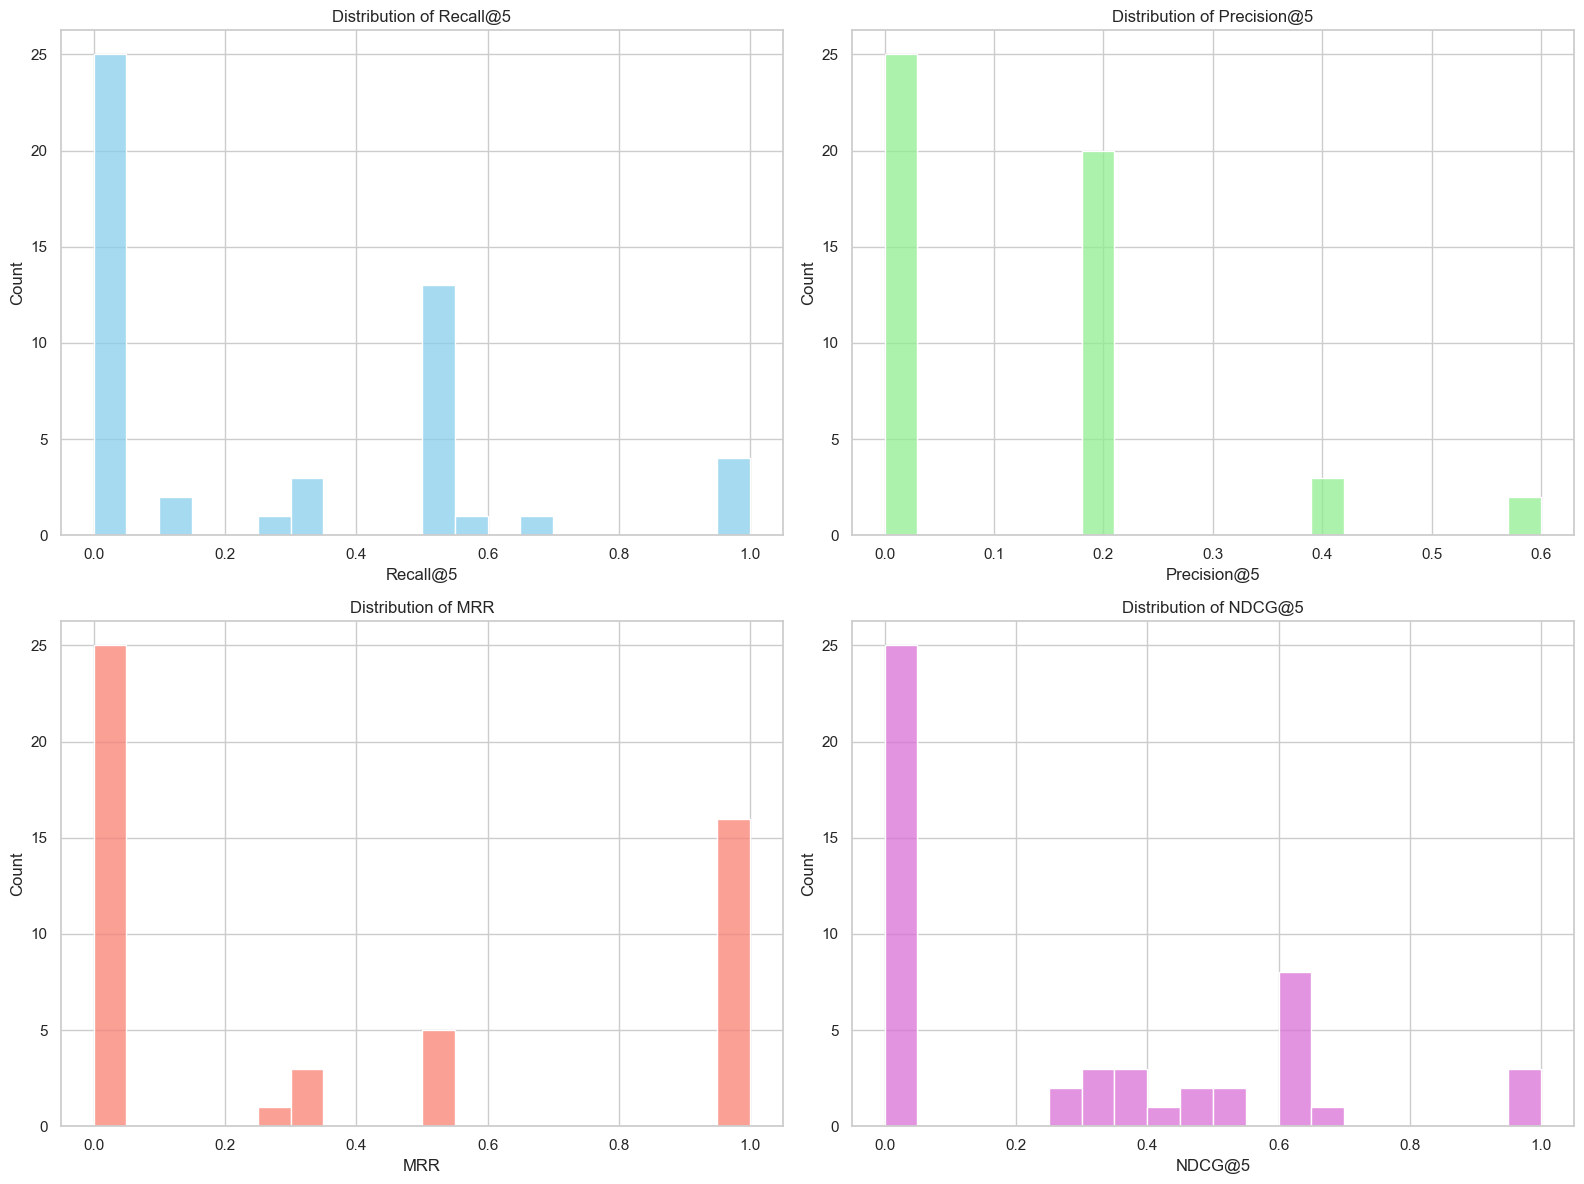


Summary Statistics:
        Recall@5  Precision@5       MRR     NDCG@5      Hit@5
count  50.000000    50.000000  50.00000  50.000000  50.000000
mean    0.266048     0.128000   0.39500   0.273903   0.500000
std     0.317902     0.155235   0.44823   0.313186   0.505076
min     0.000000     0.000000   0.00000   0.000000   0.000000
25%     0.000000     0.000000   0.00000   0.000000   0.000000
50%     0.071429     0.100000   0.12500   0.132034   0.500000
75%     0.500000     0.200000   1.00000   0.506555   1.000000
max     1.000000     0.600000   1.00000   1.000000   1.000000

Total Players Evaluated: 50
Players with Hits: 25
Players with No Hits: 25
Hit Rate@5: 0.5000


Evaluating players: 100%|███████████████████████| 50/50 [00:20<00:00,  2.39it/s]


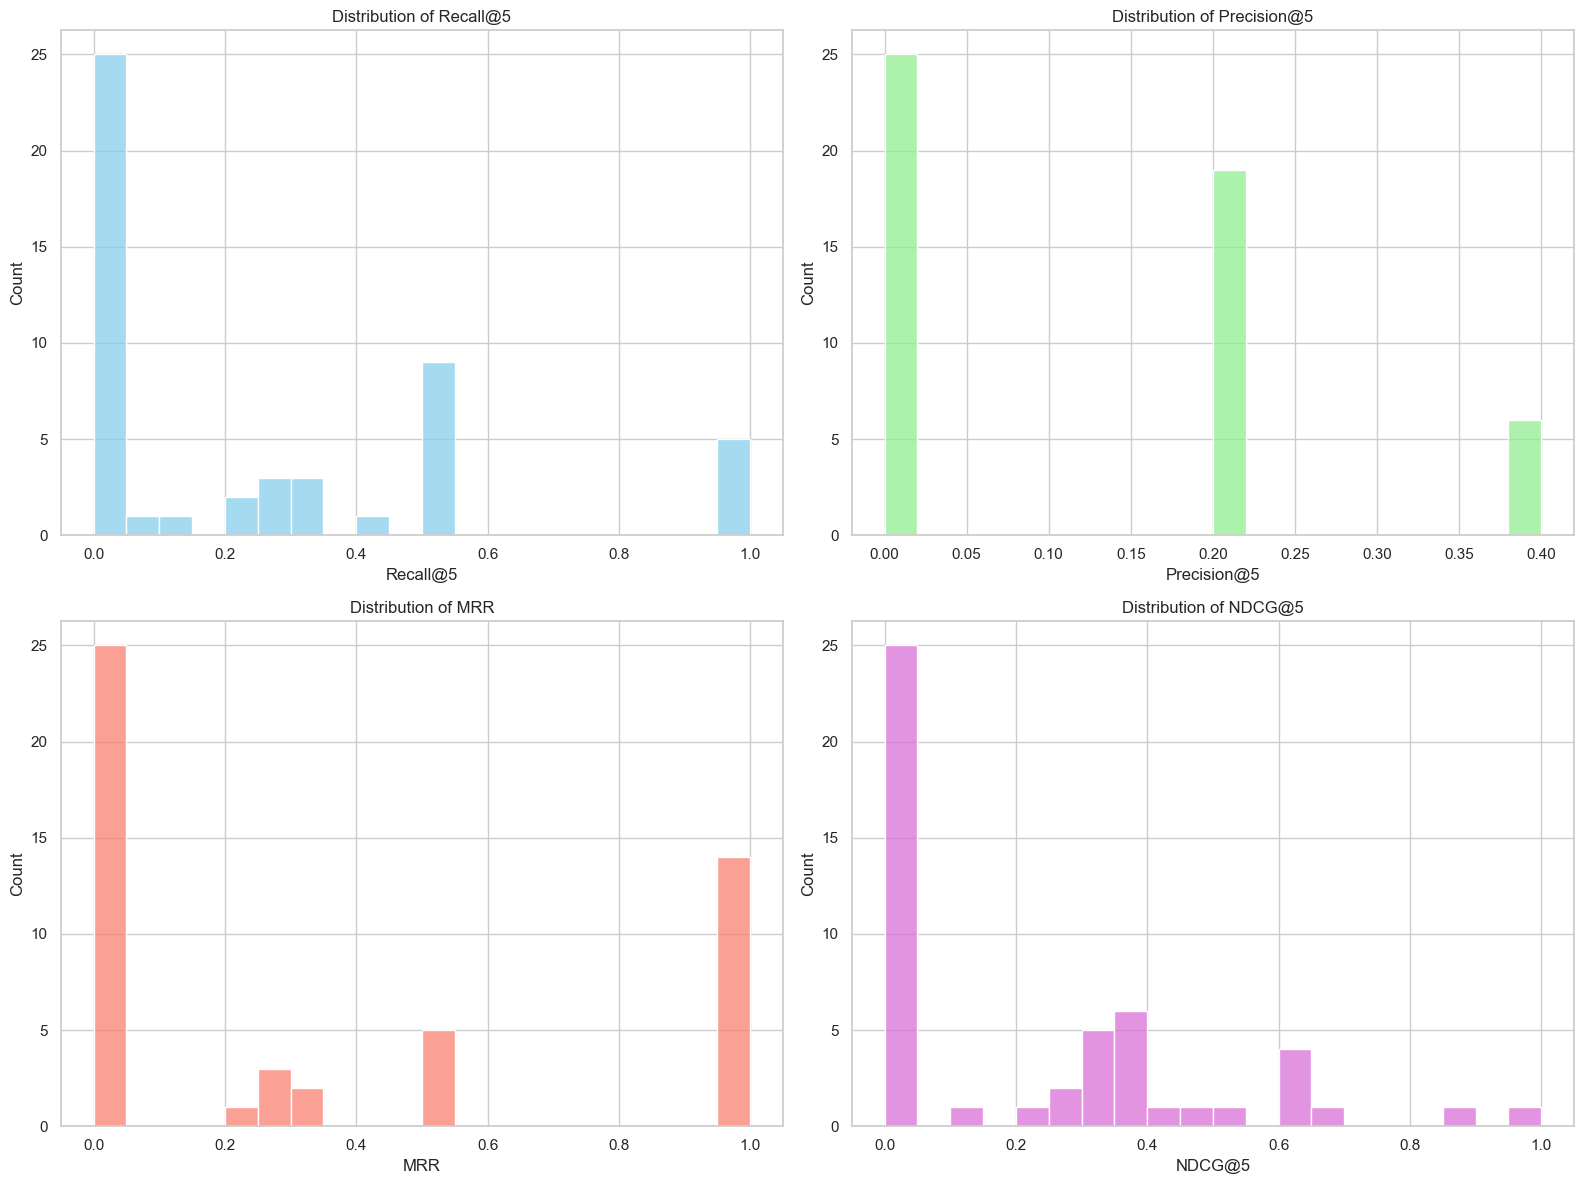


Summary Statistics:
        Recall@5  Precision@5        MRR     NDCG@5      Hit@5
count  50.000000    50.000000  50.000000  50.000000  50.000000
mean    0.244667     0.124000   0.362333   0.226987   0.500000
std     0.320544     0.139328   0.431784   0.268283   0.505076
min     0.000000     0.000000   0.000000   0.000000   0.000000
25%     0.000000     0.000000   0.000000   0.000000   0.000000
50%     0.041667     0.100000   0.100000   0.073034   0.500000
75%     0.500000     0.200000   1.000000   0.389498   1.000000
max     1.000000     0.400000   1.000000   1.000000   1.000000

Total Players Evaluated: 50
Players with Hits: 25
Players with No Hits: 25
Hit Rate@5: 0.5000


Evaluating players: 100%|███████████████████████| 50/50 [00:20<00:00,  2.40it/s]


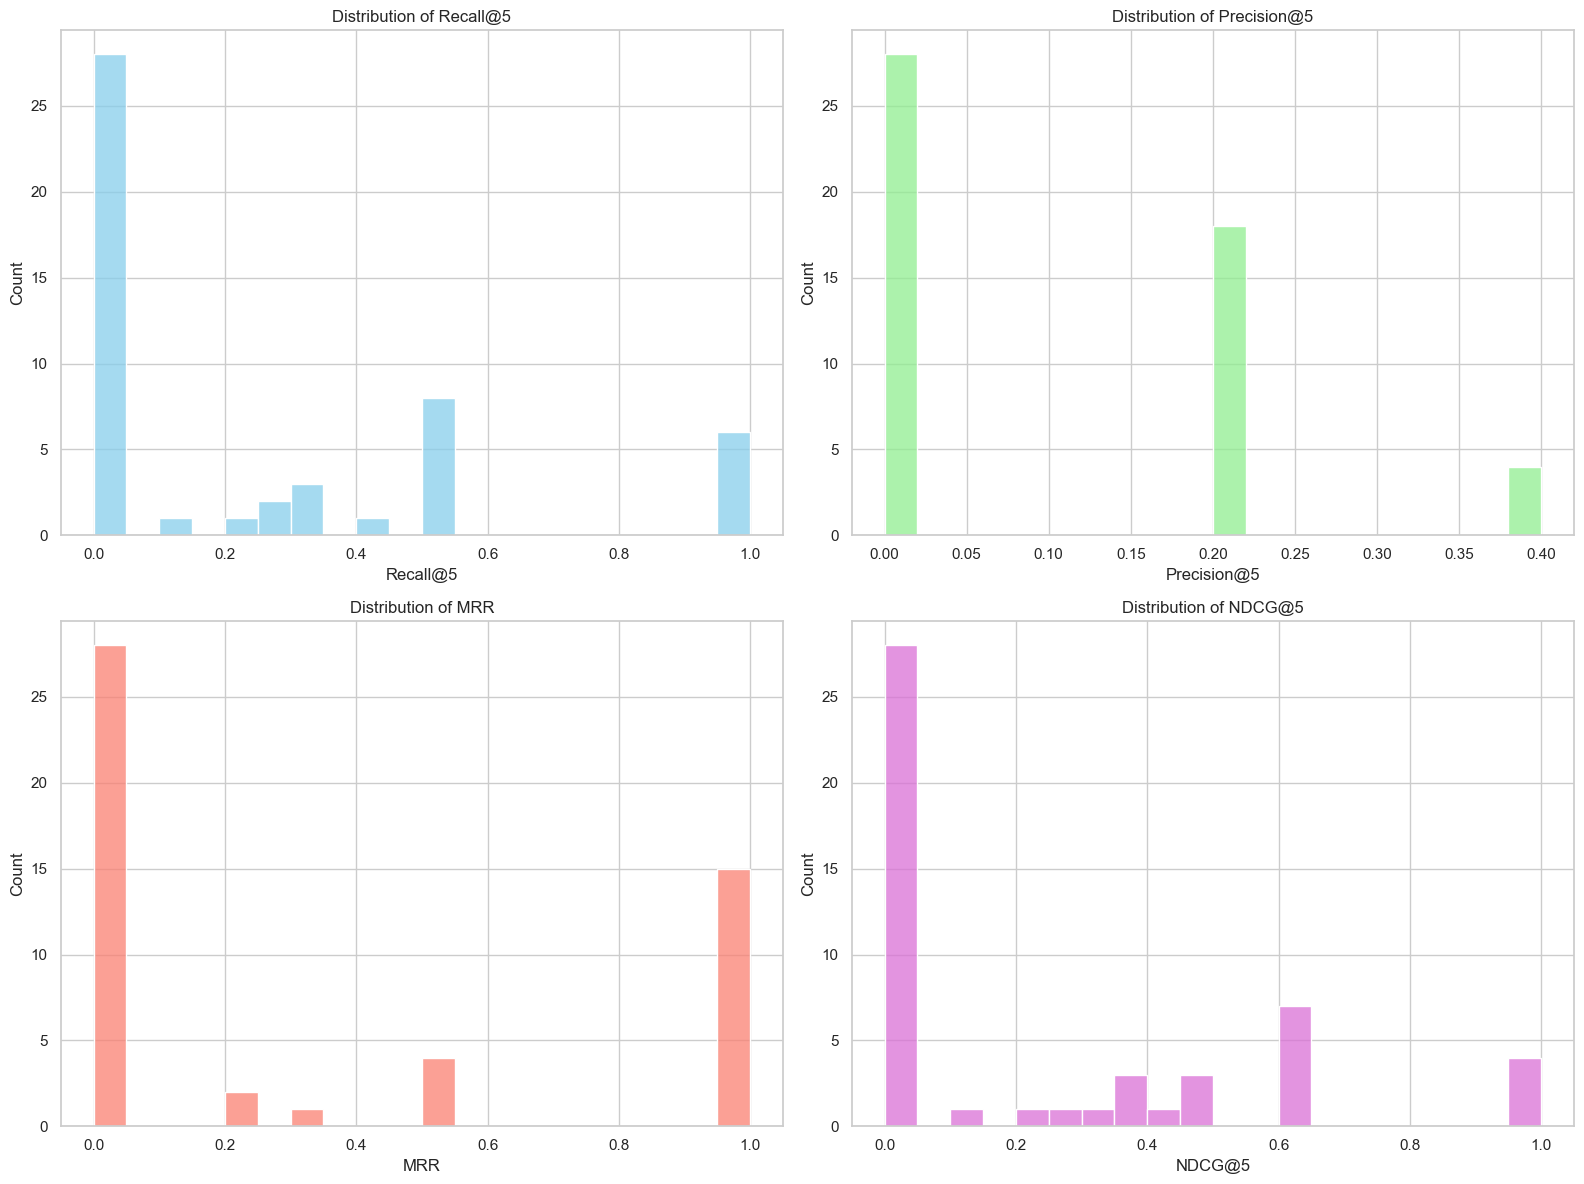


Summary Statistics:
        Recall@5  Precision@5        MRR     NDCG@5      Hit@5
count  50.000000      50.0000  50.000000  50.000000  50.000000
mean    0.244857       0.1040   0.354667   0.246282   0.440000
std     0.340498       0.1293   0.449528   0.326402   0.501427
min     0.000000       0.0000   0.000000   0.000000   0.000000
25%     0.000000       0.0000   0.000000   0.000000   0.000000
50%     0.000000       0.0000   0.000000   0.000000   0.000000
75%     0.500000       0.2000   1.000000   0.469279   1.000000
max     1.000000       0.4000   1.000000   1.000000   1.000000

Total Players Evaluated: 50
Players with Hits: 22
Players with No Hits: 28
Hit Rate@5: 0.4400


Evaluating players: 100%|███████████████████████| 50/50 [00:21<00:00,  2.37it/s]


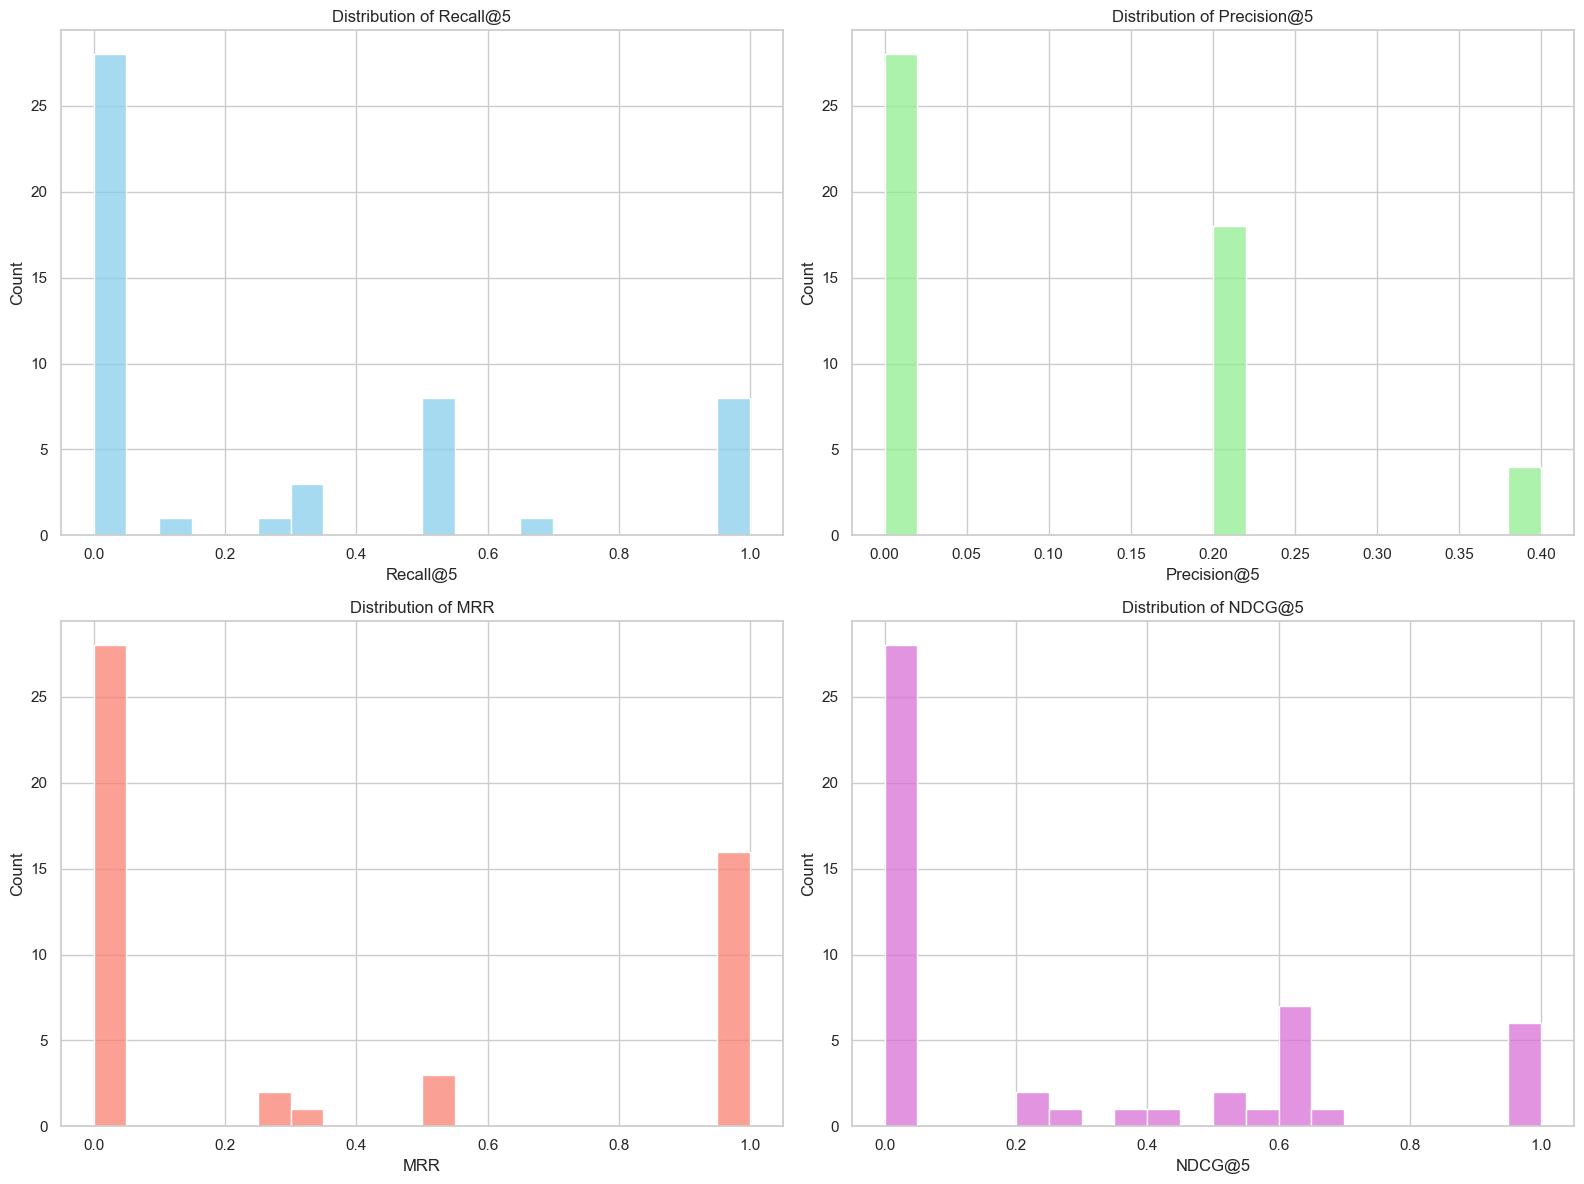


Summary Statistics:
        Recall@5  Precision@5        MRR     NDCG@5      Hit@5
count  50.000000      50.0000  50.000000  50.000000  50.000000
mean    0.281548       0.1040   0.366667   0.280689   0.440000
std     0.375570       0.1293   0.457676   0.362534   0.501427
min     0.000000       0.0000   0.000000   0.000000   0.000000
25%     0.000000       0.0000   0.000000   0.000000   0.000000
50%     0.000000       0.0000   0.000000   0.000000   0.000000
75%     0.500000       0.2000   1.000000   0.613147   1.000000
max     1.000000       0.4000   1.000000   1.000000   1.000000

Total Players Evaluated: 50
Players with Hits: 22
Players with No Hits: 28
Hit Rate@5: 0.4400


Evaluating players: 100%|███████████████████████| 50/50 [00:20<00:00,  2.46it/s]


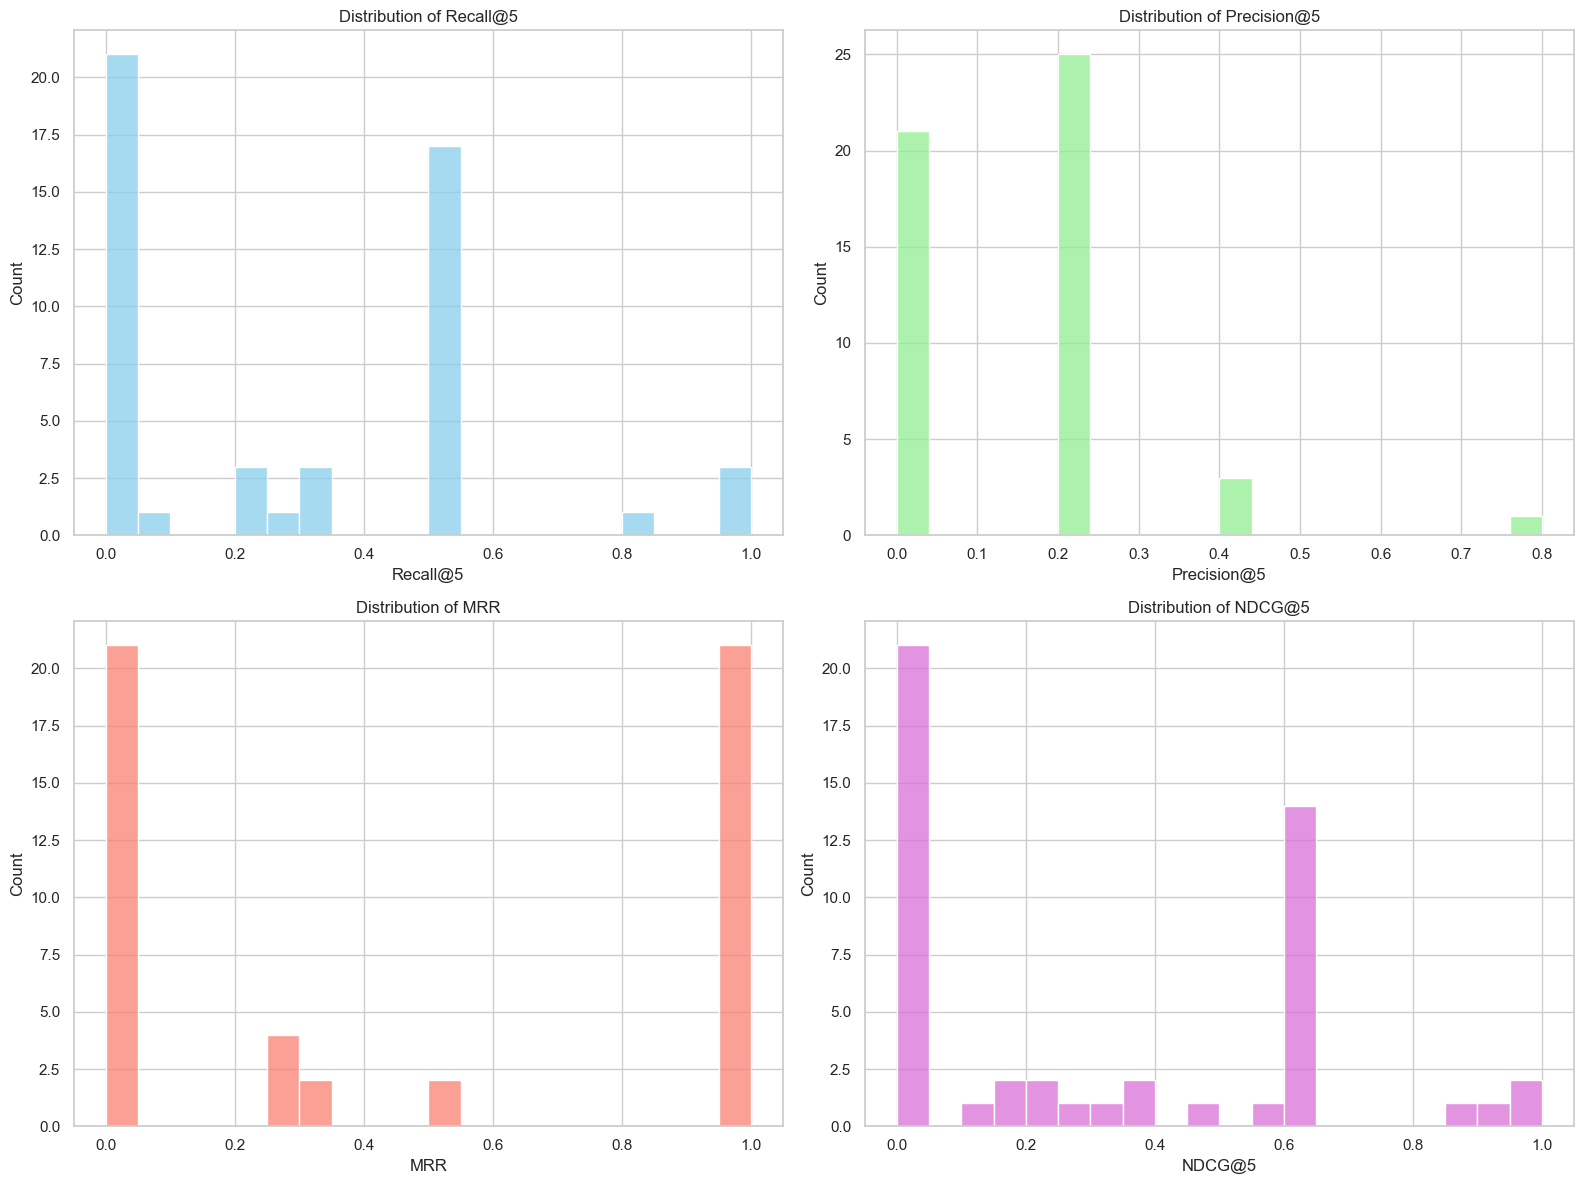


Summary Statistics:
        Recall@5  Precision@5        MRR     NDCG@5      Hit@5
count  50.000000     50.00000  50.000000  50.000000  50.000000
mean    0.284000      0.14000   0.473333   0.314023   0.580000
std     0.298825      0.15253   0.468824   0.323306   0.498569
min     0.000000      0.00000   0.000000   0.000000   0.000000
25%     0.000000      0.00000   0.000000   0.000000   0.000000
50%     0.225000      0.20000   0.291667   0.218373   1.000000
75%     0.500000      0.20000   1.000000   0.613147   1.000000
max     1.000000      0.80000   1.000000   1.000000   1.000000

Total Players Evaluated: 50
Players with Hits: 29
Players with No Hits: 21
Hit Rate@5: 0.5800

### Best Weights per Metric ###
RECALL: 0.3233 at weights alpha=0.50, beta=0.01, gamma=0.49
PRECISION: 0.2080 at weights alpha=0.50, beta=0.01, gamma=0.49
MRR: 0.5573 at weights alpha=0.50, beta=0.01, gamma=0.49
NDCG: 0.3730 at weights alpha=0.50, beta=0.01, gamma=0.49


In [8]:
alpha_vals = [0.5, 0.7, 0.9]
beta_vals = [0.01, 0.1, 0.2]

best_scores = {
    "recall": 0,
    "precision": 0,
    "mrr": 0,
    "ndcg": 0
}

best_weights = {
    "recall": None,
    "precision": None,
    "mrr": None,
    "ndcg": None
}

for alpha in alpha_vals:
    for beta in beta_vals:
        gamma = 1.0 - alpha - beta
        if gamma < 0:
            continue  # Skip invalid combinations

        evaluation_results = evaluate_on_test_set(
            test_df, player_game_matrix, game_genre, game_category, player_country,
            sample_size=50,
            alpha=alpha, beta=beta, gamma=gamma, top_n=5
        )

        recall = evaluation_results['Recall@5'].mean()
        precision = evaluation_results['Precision@5'].mean()
        mrr = evaluation_results['MRR'].mean()
        ndcg = evaluation_results['NDCG@5'].mean()

        if recall > best_scores["recall"]:
            best_scores["recall"] = recall
            best_weights["recall"] = (alpha, beta, gamma)

        if precision > best_scores["precision"]:
            best_scores["precision"] = precision
            best_weights["precision"] = (alpha, beta, gamma)

        if mrr > best_scores["mrr"]:
            best_scores["mrr"] = mrr
            best_weights["mrr"] = (alpha, beta, gamma)

        if ndcg > best_scores["ndcg"]:
            best_scores["ndcg"] = ndcg
            best_weights["ndcg"] = (alpha, beta, gamma)

# Print summary
print("\n### Best Weights per Metric ###")
for metric in best_scores:
    print(f"{metric.upper()}: {best_scores[metric]:.4f} at weights alpha={best_weights[metric][0]:.2f}, "
          f"beta={best_weights[metric][1]:.2f}, gamma={best_weights[metric][2]:.2f}")


In [15]:
print("\n### Best Weights per Metric ###")
print(f"{'Metric':<10} {'Score':<10} {'Alpha':<10} {'Beta':<10} {'Gamma':<10}")
print("-" * 50)

for metric in best_scores:
    score = best_scores[metric]
    alpha, beta, gamma = best_weights[metric]
    print(f"{metric.upper():<10} {score:<10.4f} {alpha:<10.2f} {beta:<10.2f} {gamma:<10.2f}")



### Best Weights per Metric ###
Metric     Score      Alpha      Beta       Gamma     
--------------------------------------------------
RECALL     0.3233     0.50       0.01       0.49      
PRECISION  0.2080     0.50       0.01       0.49      
MRR        0.5573     0.50       0.01       0.49      
NDCG       0.3730     0.50       0.01       0.49      


# Hyperparamter Optimized

Evaluating players: 100%|███████████████████████| 50/50 [00:20<00:00,  2.41it/s]


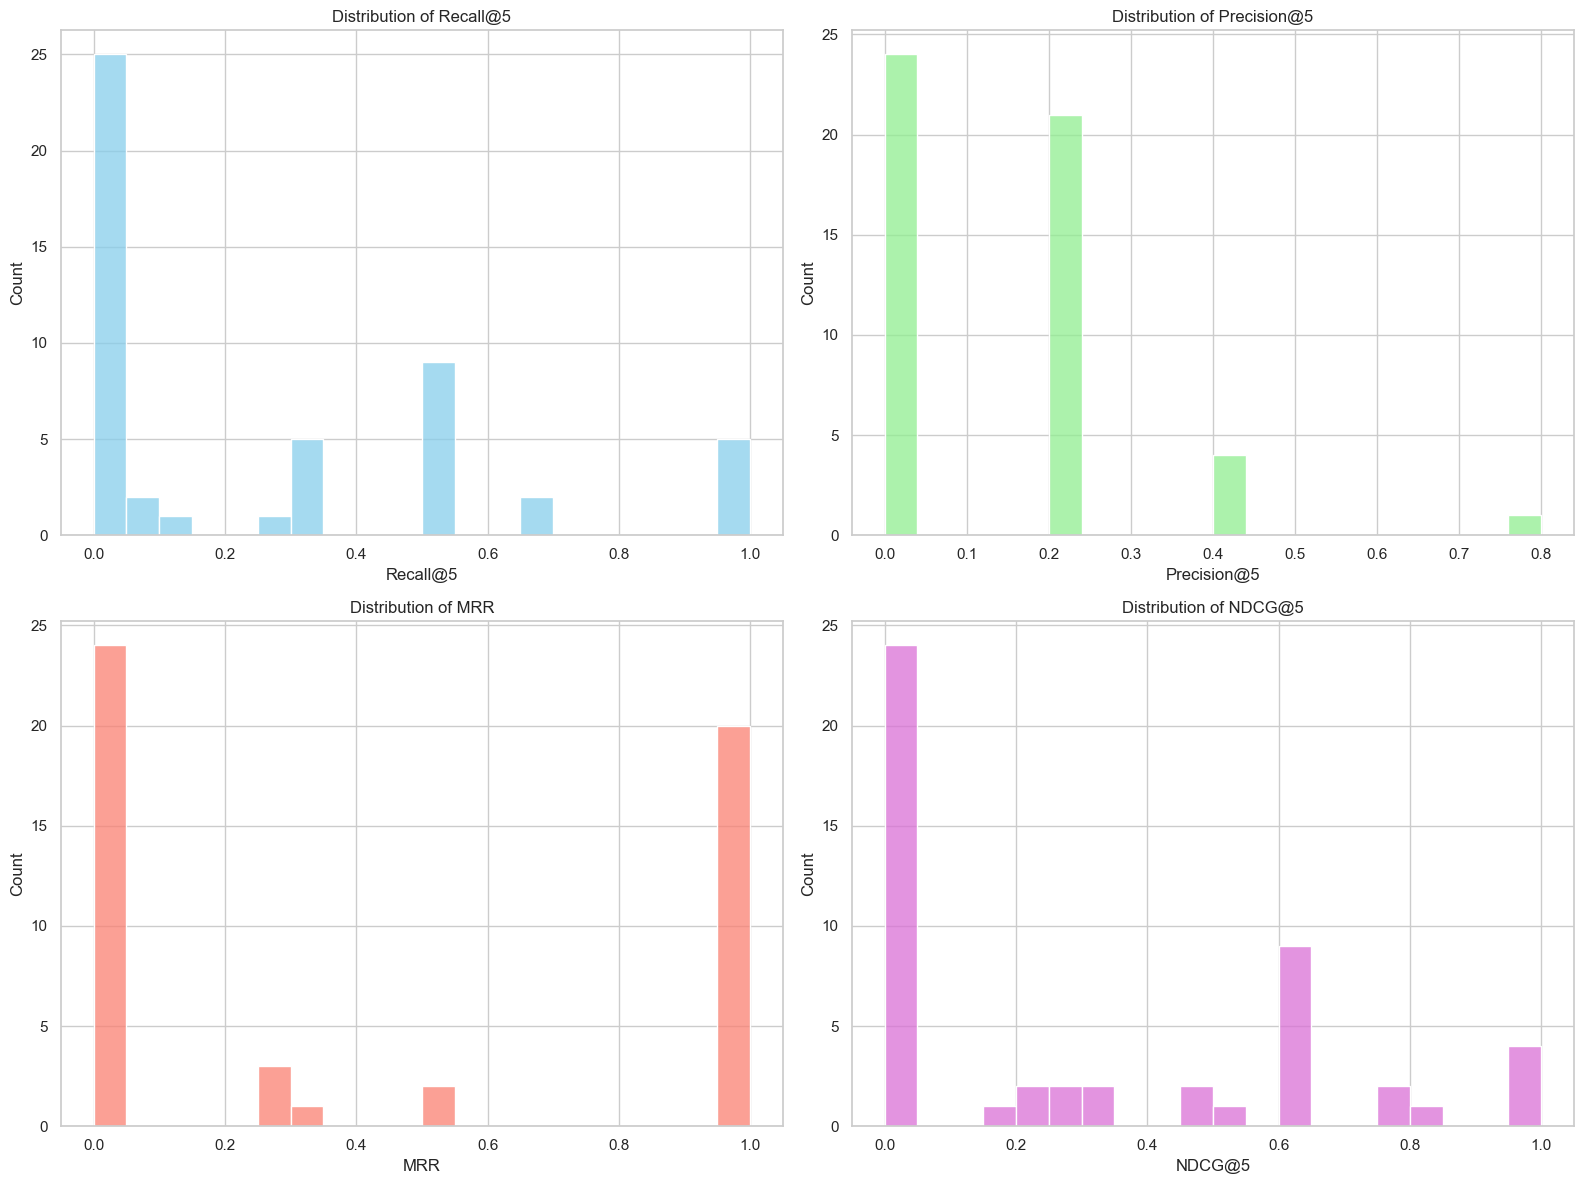


Summary Statistics:
        Recall@5  Precision@5        MRR     NDCG@5      Hit@5
count  50.000000    50.000000  50.000000  50.000000  50.000000
mean    0.260775     0.132000   0.441667   0.303136   0.520000
std     0.331428     0.159642   0.474775   0.346098   0.504672
min     0.000000     0.000000   0.000000   0.000000   0.000000
25%     0.000000     0.000000   0.000000   0.000000   0.000000
50%     0.043403     0.200000   0.250000   0.185844   1.000000
75%     0.500000     0.200000   1.000000   0.613147   1.000000
max     1.000000     0.800000   1.000000   1.000000   1.000000

Total Players Evaluated: 50
Players with Hits: 26
Players with No Hits: 24
Hit Rate@5: 0.5200

 ### Evaluation Metrics ###
Average Recall@5: 0.2607745726495726
Average Precision@5: 0.13200000000000003
Average MRR: 0.44166666666666665
Average NDCG@5: 0.3031362293343018
HitRate@5: 0.494
Recommended Games: ['Super Mario 64 Category Extensions', 'SM64 Sapphire', 'Portal', 'Super Mario Odyssey', 'Minecraft: Java 

In [10]:
# Set fixed weights
# Experiment and do ablation study of just a few weight changes?
alpha = 0.5
beta = 0.01
gamma = 0.49

# Evaluate the model with these fixed weights
evaluation_results = evaluate_on_test_set(
            test_df, player_game_matrix, game_genre, game_category, player_country,
            sample_size=50,
            alpha=alpha, beta=beta, gamma=gamma, top_n=5
        )

print("\n ### Evaluation Metrics ###")
print("Average Recall@5:", evaluation_results['Recall@5'].mean())
print("Average Precision@5:", evaluation_results['Precision@5'].mean())
print("Average MRR:", evaluation_results['MRR'].mean())
print("Average NDCG@5:", evaluation_results['NDCG@5'].mean())
print("HitRate@5:", results['Hit@5'].mean())

# Example of player who played Celeste and Super Mario 64
user_games = ['Celeste', 'Super Mario 64']
recommendations = recommend_hybrid(
    player_game_matrix, game_genre, game_category, player_country,
    user_games,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    top_n=5
)

print("Recommended Games:", recommendations)